In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Modelling steps 1 and 2.
## Saves transport demand between zones
## Needs zones

In [2]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_zones')

### Emission and attraction with quetzal


Steps: Generation and distribution --> Transport demand in volumes<br>
Transport volumes can be generated by using the function<br>

step_distribution(impedance_matrix=None, **od_volume_from_zones_kwargs)<br>
    :param impedance_matrix: an OD unstaked friction dataframe<br>
        used to compute the distribution.<br>
    :param od_volume_from_zones_kwargs: if the friction matrix is not<br>
        provided, it will be automatically computed using a gravity<br>
        distribution which uses the following parameters:<br>
        param power: (int) the gravity exponent<br>
        param intrazonal: (bool) set the intrazonal distance to 0 if False,<br>
            compute a characteristic distance otherwise.<br>
            
Or create the volumes from input data<br>

### Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [4]:
vp2010 = pd.read_excel(input_path + 'PVMatrix_BVWP15_A2010.xlsx')
vp2030 = pd.read_excel(input_path + 'PVMatrix_BVWP15_P2030.xlsx')

In [5]:
print(vp2010.shape)
vp2010[vp2010.isna().any(axis=1)]

(313590, 38)


,# Quelle,Ziel,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6


In [6]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

In [7]:
def get_vp2017(vp2010_i, vp2030_i):
    return vp2010_i + (vp2030_i - vp2010_i) * (7/20)

In [8]:
# Calculate a OD table for the year 2017
vp2017 = get_vp2017(vp2010.set_index(['origin', 'destination']),
                    vp2030.set_index(['origin', 'destination']))

In [9]:
vp2017.dropna(how='all', inplace=True)
print(vp2010.shape)
vp2017[vp2017.isna().any(axis=1)]

(313590, 38)


,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,


In [10]:
vp2017 = vp2017[list(vp2017.columns)].astype(int)
#vp2017.head()

### Create the volumes table

In [11]:
# Sum up trips by purpose
for suffix in ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz5', 'Fz6']:
    vp2017[suffix] = vp2017[[col for col in list(vp2017.columns) if col[-3:] == suffix]].sum(axis=1)

In [12]:
# Merge purpose 5 and 6 due to calibration data limitations
vp2017['Fz6'] = vp2017['Fz5'] + vp2017['Fz6']

In [13]:
# Replace LAU IDs with NUTS IDs in origin and destination
nuts_lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp2017.reset_index(level=['origin', 'destination'], inplace=True)

In [14]:
# Zones that appear in the VP (within Germany) but not in the model
sorted([i for i in set(list(vp2017['origin'])+list(vp2017['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3152,
 3156,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 13001,
 13002,
 13005,
 13006,
 13051,
 13052,
 13053,
 13054,
 13055,
 13056,
 13057,
 13058,
 13059,
 13060,
 13061,
 13062,
 14109,
 14119]

In [15]:
# Most of the above numbers are airports in the VP, however
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075}

In [16]:
# What is the sum of all trips? For Validation
cols = [c for c in vp2017.columns if c not in ['origin', 'destination']]
orig_sum = vp2017[cols].sum().sum()
orig_sum

204502101389

In [17]:
# Update LAU codes
vp2017['origin'] = vp2017['origin'].replace(update_dict)
vp2017['destination'] = vp2017['destination'].replace(update_dict)

In [18]:
sorted([i for i in set(list(vp2017['origin'])+list(vp2017['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 14109,
 14119]

In [19]:
# Replace LAU with NUTS
vp2017['origin'] = vp2017['origin'].astype(str).map(nuts_lau_dict)
vp2017['destination'] = vp2017['destination'].astype(str).map(nuts_lau_dict)

In [20]:
# Restrict to cells in the model
vp2017 = vp2017[~vp2017.isna().any(axis=1)]

In [21]:
vp2017.shape

(169744, 44)

In [22]:
# What is the sum of all trips after ditching outer-German trips?
vp_sum = vp2017[cols].sum().sum()
vp_sum / orig_sum

0.9880382360504606

### Save model

In [23]:
sm.volumes = vp2017[['origin', 'destination', 'Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']].copy()

In [24]:
sm.volumes.shape

(169744, 7)

In [25]:
# Empty rows?
sm.volumes.loc[sm.volumes.sum(axis=1)==0]

,origin,destination,Fz1,Fz2,Fz3,Fz4,Fz6


In [26]:
# Saving volumes
sm.to_json(model_path + 'de_volumes', only_attributes=['volumes'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 49.32it/s]


### Create validation table

Generate a normalised matrix for the year 2017 in order to validate model results against each other. It is needed for the calibration step.

In [27]:
# Merge purpose 5 and 6
for prefix in ['Bahn', 'MIV', 'Luft', 'OESPV', 'Rad', 'Fuß']:
    vp2017[prefix + '_Fz6'] = vp2017[prefix + '_Fz5'] + vp2017[prefix + '_Fz6']
vp2017 = vp2017[[col for col in list(vp2017.columns) if col[-1]!='5']]

In [28]:
# Merge bicycle and foot
for p in [1,2,3,4,6]:
    vp2017['non_motor_Fz' + str(p)] = vp2017['Rad_Fz' + str(p)] + vp2017['Fuß_Fz' + str(p)]
vp2017 = vp2017[[col for col in list(vp2017.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [29]:
# Prepare columns
vp2017.set_index(['origin', 'destination'], drop=True, inplace=True)
vp2017 = vp2017[[col for col in vp2017.columns if col[:2]!='Fz']]
vp2017.columns

Index(['Bahn_Fz1', 'Bahn_Fz2', 'Bahn_Fz3', 'Bahn_Fz4', 'Bahn_Fz6', 'MIV_Fz1',
       'MIV_Fz2', 'MIV_Fz3', 'MIV_Fz4', 'MIV_Fz6', 'Luft_Fz1', 'Luft_Fz2',
       'Luft_Fz3', 'Luft_Fz4', 'Luft_Fz6', 'OESPV_Fz1', 'OESPV_Fz2',
       'OESPV_Fz3', 'OESPV_Fz4', 'OESPV_Fz6', 'non_motor_Fz1', 'non_motor_Fz2',
       'non_motor_Fz3', 'non_motor_Fz4', 'non_motor_Fz6'],
      dtype='object')

In [30]:
# Normalise
vp2017_norm = (vp2017-vp2017.min())/(vp2017.max()-vp2017.min()).max()

In [31]:
vp2017_norm.sample(5)

,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,MIV_Fz6,...,OESPV_Fz1,OESPV_Fz2,OESPV_Fz3,OESPV_Fz4,OESPV_Fz6,non_motor_Fz1,non_motor_Fz2,non_motor_Fz3,non_motor_Fz4,non_motor_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,
DEB37,DE11A,0.000000,0.000000,0.000000e+00,3.323819e-09,2.825246e-08,0.000000,0.000000,0.000000,2.118934e-06,0.000007,...,0.0,0.0,0.0,0.0,4.537012e-07,0.0,0.0,0.0,0.0,0.0
DEB3E,DE246,0.000000,0.000000,0.000000e+00,0.000000e+00,1.329527e-08,0.000000,0.000000,0.000000,2.825246e-08,0.000001,...,0.0,0.0,0.0,0.0,3.490010e-08,0.0,0.0,0.0,0.0,0.0
DEA27,DEB1B,0.000003,0.000002,4.287726e-07,1.080241e-07,2.664041e-06,0.000087,0.000013,0.000055,2.105639e-05,0.000096,...,0.0,0.0,0.0,0.0,1.241446e-06,0.0,0.0,0.0,0.0,0.0
DE218,DEA1C,0.000000,0.000000,0.000000e+00,7.312401e-08,2.875103e-07,0.000000,0.000000,0.000000,2.077387e-07,0.000003,...,0.0,0.0,0.0,0.0,3.822391e-08,0.0,0.0,0.0,0.0,0.0
DE947,DE736,0.000000,0.000000,0.000000e+00,0.000000e+00,1.678528e-07,0.000000,0.000000,0.000000,1.445861e-07,0.000002,...,0.0,0.0,0.0,0.0,1.528957e-07,0.0,0.0,0.0,0.0,0.0


In [32]:
# Save normalised table
vp2017_norm.to_csv(input_path + 'vp2017_validation_normalised.csv')

In [33]:
vp2017_norm.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[0], col.split('_')[-1]) for col in vp2017_norm.columns],
    names=['mode', 'segment'])

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

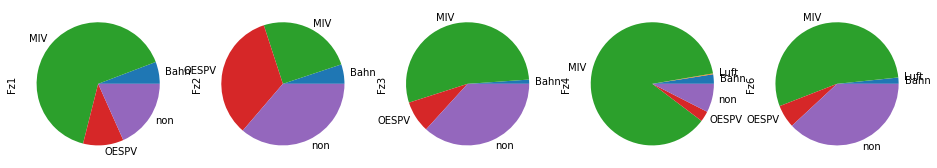

In [34]:
vp2017_norm.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

In [35]:
# Restrict to inter-cell traffic and cells of the model
vp2017_norm.reset_index(level=['origin', 'destination'], inplace=True)
vp2017_norm = vp2017_norm.loc[(vp2017_norm['origin']!=vp2017_norm['destination']) &
                    (vp2017_norm['origin'].notna()) &
                    (vp2017_norm['destination'].notna())]
vp2017_norm.set_index(['origin', 'destination'], drop=True, inplace=True)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

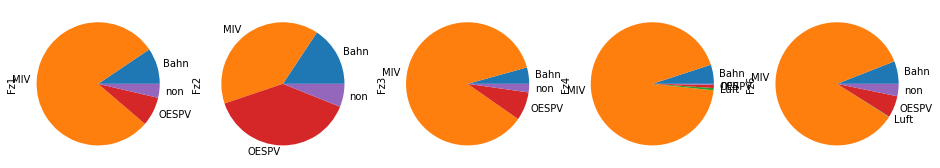

In [36]:
vp2017_norm.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

In [37]:
# Clear the RAM if notebook stays open
vp2010 = None
vp2030 = None